In [66]:
import pandas as pd
import numpy as np
import warnings
import os
import tqdm

from sklearn.preprocessing import StandardScaler

from src.model_clustering import *
from src.plots import *
from src.features import *
from src.metrics import *

from sklearn.manifold import TSNE, MDS
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.metrics import make_scorer

warnings.filterwarnings('ignore')

In [67]:
# Data reading
DATA_SOURCE = 'D:\AI-Projects\Machine_Learning\ENG\TLC_NY_Trip_Demand_Prediction\processed_data'
SEED=23
os.chdir(DATA_SOURCE)

# Series for model training and clustering
train_data = pd.read_csv('train_data.csv', parse_dates=['tpep_pickup_datetime'])

# Series r that needs to be clustered and made a prediction
cluster_serieses = pd.read_csv('cluster_serieses.csv', parse_dates=['tpep_pickup_datetime'])

# Inference
inference_data = pd.read_csv('inference_data.csv', parse_dates=['tpep_pickup_datetime'])

In [68]:
# Change the appearance of the table (Columns - observations in the time series)
train_data = train_data.pivot(index='PULocationID', columns='tpep_pickup_datetime', values='n_trips').reset_index()

# Scale the series (each series is scaled independently)
scaler = StandardScaler()

# The first time we transpose to scale each series independently (the column describes the district series)
# second time - return the scaled ticks of the series as features
scaled_train = scaler.fit_transform(train_data.iloc[:, 1:].T).T 

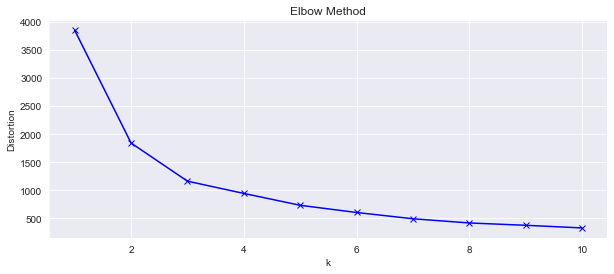

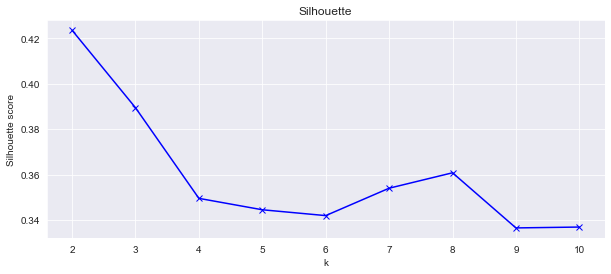

In [120]:
# Get features in 2D
tsne = TSNE(n_components=2, init='pca', random_state=SEED)
data_tsne = tsne.fit_transform(scaled_train)

get_kmeans_results(data=data_tsne, max_clusters=10, metric='euclidean', seed=SEED)

In [126]:
# Обучаем TimeSeriesKMeans с t-SNE
kmeans_model = TimeSeriesKMeans(n_clusters=3, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)

# Cluster labels 
cluster_labels = kmeans_model.fit_predict(data_tsne)

# Apply reverse scaling (because we will be generating features, we will need to apply scaling again)
# Don't want to apply scaling twice
unscaled_train = scaler.inverse_transform(scaled_train.T).T

# Clustered series 
ts_clustered = [unscaled_train[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

### Cluster Target Series
**As a target series of the cluster, we will use the series that are closest to the centroids of the clusters**

In [127]:
# Determine the indices of the series
closest_clusters_indxs = [np.argmin([np.linalg.norm(cluster_center - point, ord=2) for point in data_tsne]) \
                                                                        for cluster_center in kmeans_model.cluster_centers_]

# Target series - Closest Series to Cluster Centroid
centroids_serieses = unscaled_train[closest_clusters_indxs, :]

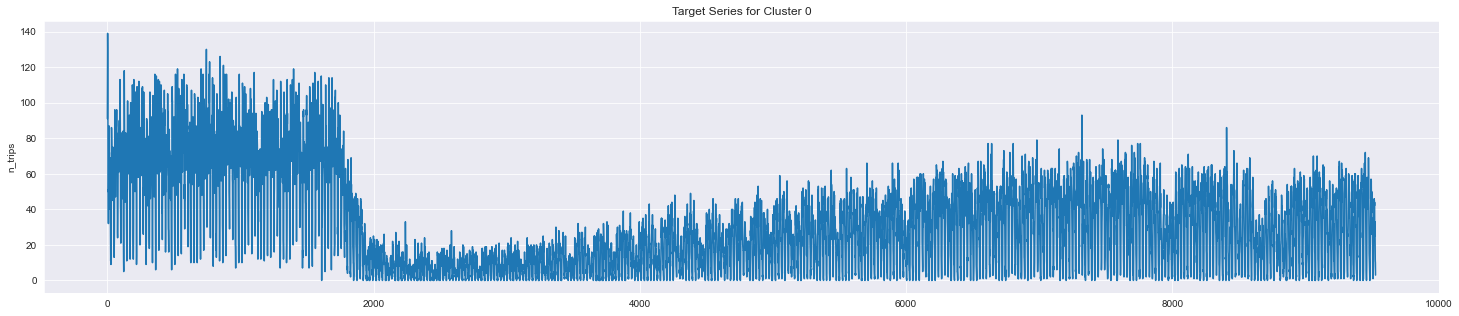

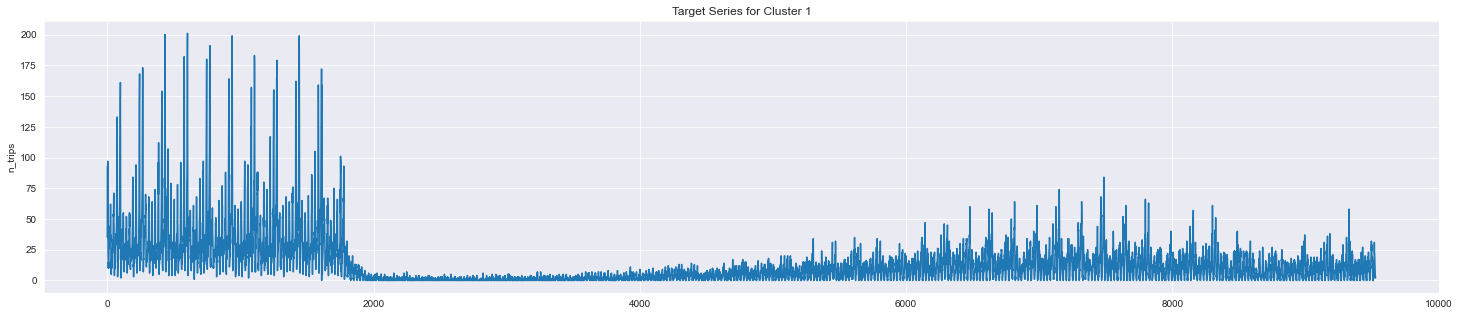

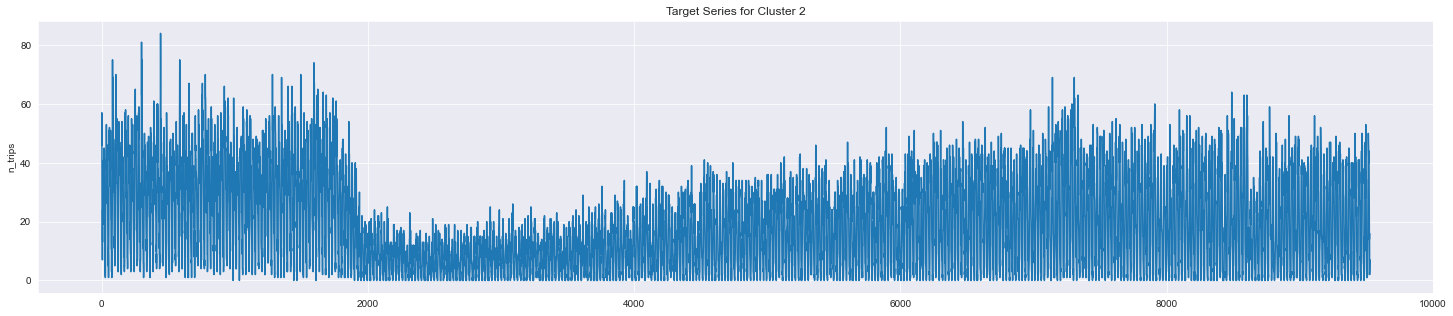

In [128]:
# let's look at target series 
def plot_series(ts, cluster_indx=''):
    plt.figure(figsize=(25,5))
    plt.plot(ts)
    plt.ylabel('n_trips')
    plt.title(f'Target Series for Cluster {cluster_indx}')
    plt.grid(True);
    
for indx, ts in enumerate(centroids_serieses):
    plot_series(ts, cluster_indx=indx)

### Feature Extraction
To predict time series, we can independently extract features from a series and predict using linear (linear regression) and non-linear models (trees)

### Date-Time Related Features
We can extract the following features of time from the series:
- Second, Minute, Hour
- Day of the Month, Week, Month, Day of the Week
- Working hours or not
- Season (summer, winter...)
- Holiday/Day off
- Lunchtime

**Important**

If we have data for a year, then the features calculated within the year will not be informative. Most likely it will be noise. The model doesn't have enough data to generalize (dependencies cannot be extracted, since we have a pattern without repetition and it isn't certain that it will repeat similarly in the next time periods, there is a risk of overfitting)

Examples of such features:
- Month of the Year/Name of the Month
- Week of the Year
- Year/Time of Year/Start-End of Year/Day of Year

The resulting time features need to be visualized (for example, consider the average number of the target feature over the generated time features) in order to determine/extract additional dependencies


Consider the generation of these features on the first cluster

In [75]:
# Target series for the first cluster
target_series = pd.DataFrame(centroids_serieses[0].T, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])

Extract time features and look at the dependencies (average number of trips for the extracted periods)

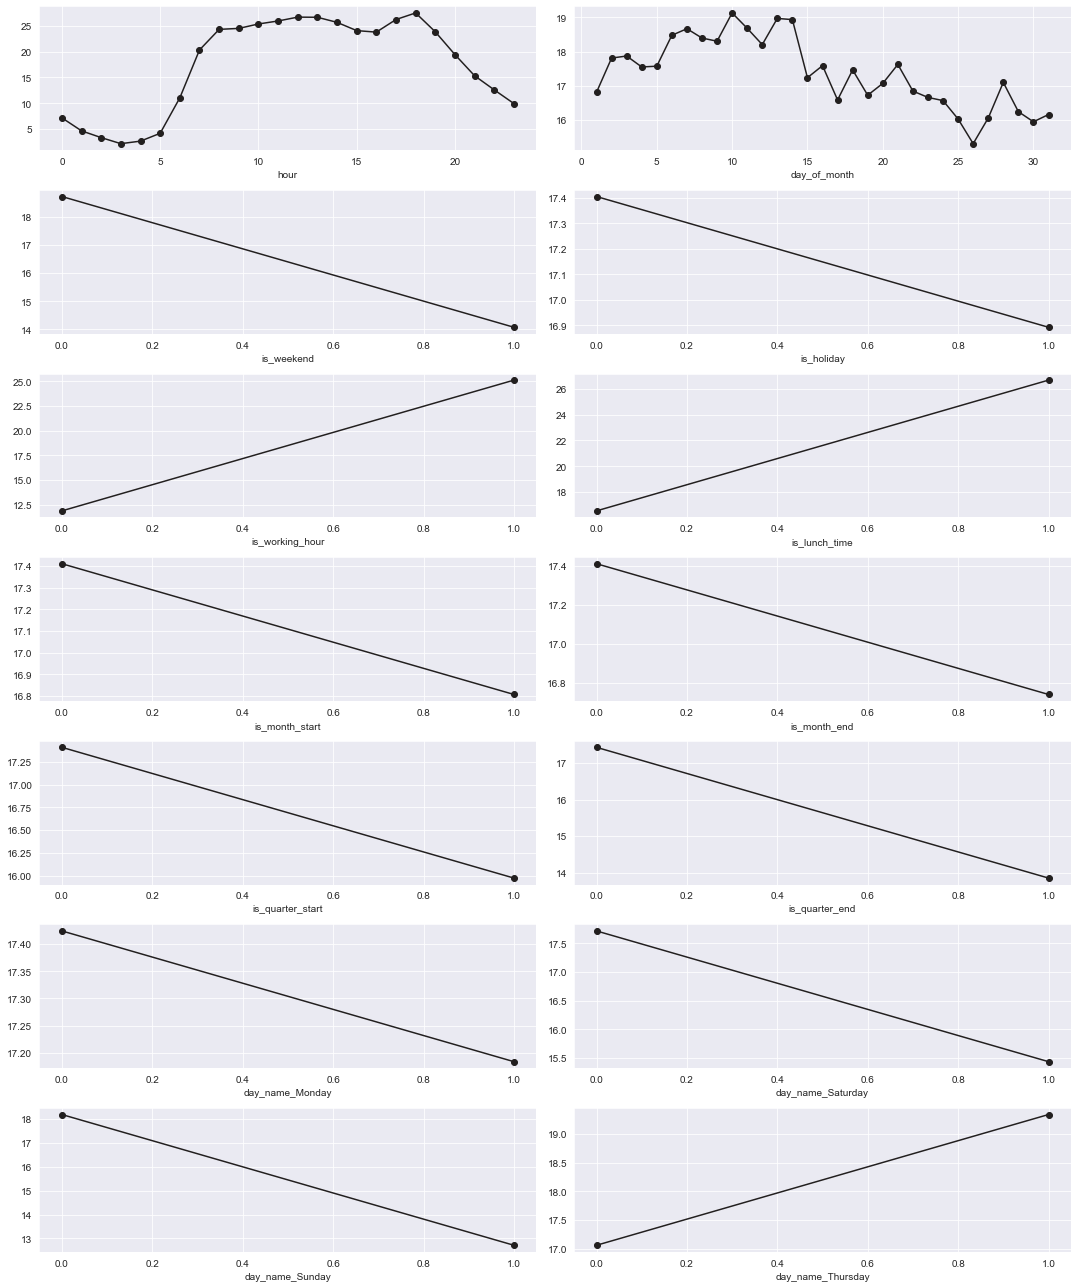

In [27]:
# Features 
features = get_time_features(target_series)
feature_names = features.columns[1:]
black = "#221f1f"

# Visualize
fig, ax = plt.subplots(7, 2, figsize=(15, 18))
for feature, ax in zip(feature_names, ax.flatten()):
    grouped = features.groupby(feature)["n_trips"].mean()
    grouped.plot(ax=ax, color=black, marker="o")
    
plt.tight_layout()

**Short Summary**
- `hour: gradual increase from morning to 12 and peak at 14, then a gradual decrease)`
- `day_name: demand is lower on weekends than on weekdays`
- `is_holiday: demand is lower on holidays`
- `is_lunch_time: increased demand at lunchtime`
- `is_working_hours: high demand during working hours`

Since we need to build several models at once, it would be interesting to see how important the extracted features are for each series separately.**

We will use `Lasso Regression` with some regularization coefficient values.

It is also necessary to define the target metric, while we will stop at `MAPE`

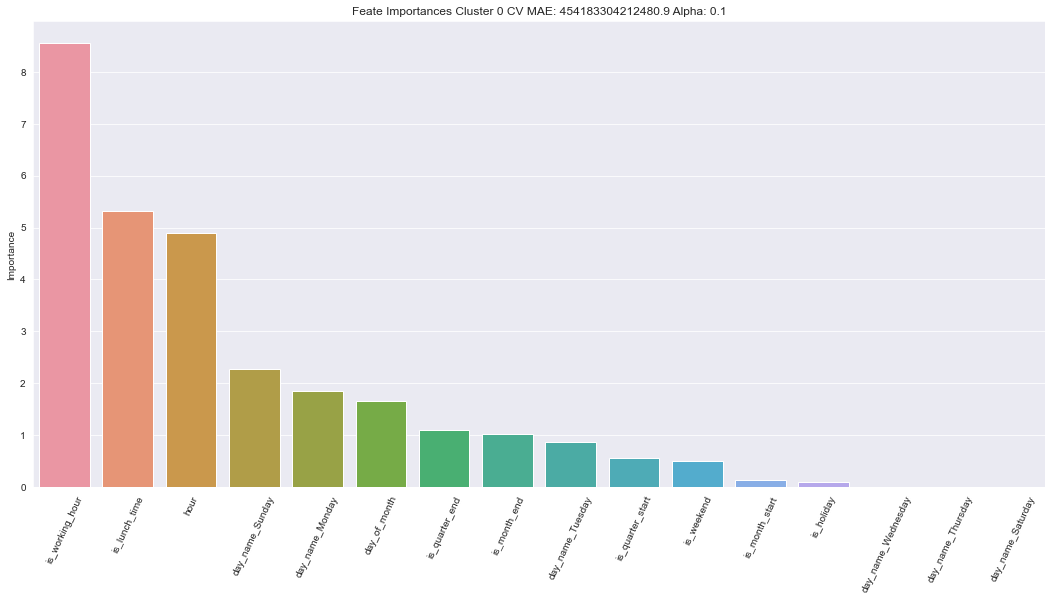

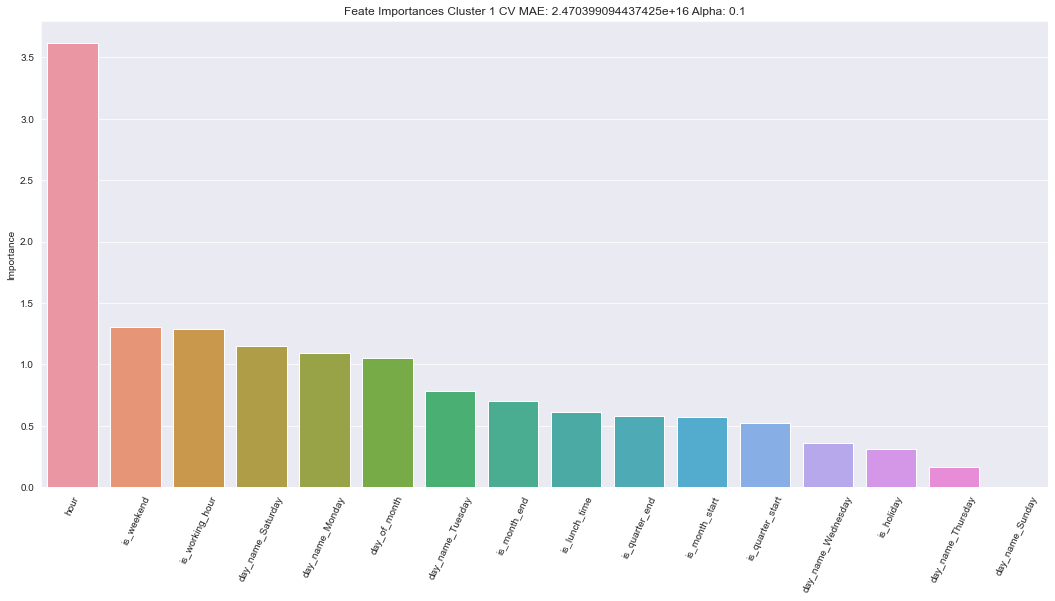

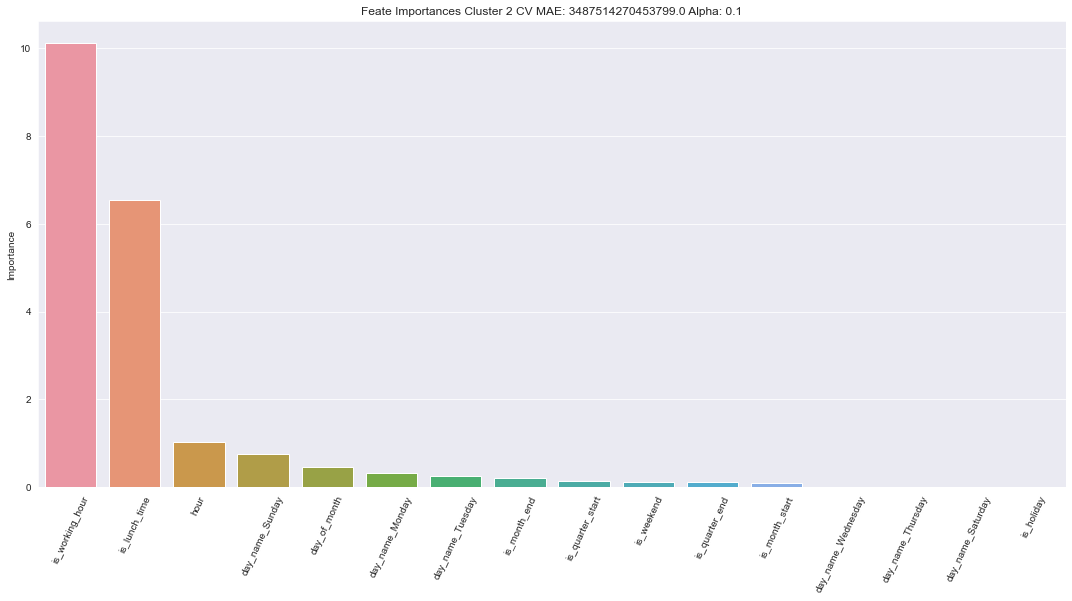

In [76]:
alphas = np.logspace(-5, -1, 10)

model_pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', LassoCV(cv=TimeSeriesSplit(5), alphas=alphas))
])

for indx, series in enumerate(centroids_serieses):
    series = pd.DataFrame(series, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])
    features = get_time_features(series, is_cyclical_encoding=False)
    show_features_importances(model_pipe, features, n_splits=5, 
                              scoring='neg_mean_absolute_percentage_error', target_col_name='n_trips', cluster_indx=indx)

You can see how differently important the features are for the series. There are rows for which the obtained features are not important, for example, cluster 2

Values of MAPE metric is not important for now (in all cases it is large - there are not enough features)


### Lag Features
The target variable can also be used to build new features. For prediction per step `t+1`, it may turn out that the value at a  time `t` is highly dependent on the value at a time `t-1`. Such past values of the series are called lags (lag variables). For example, to calculate the `t-1` lag (feature), it is necessary to shift the series by 1 value forward (forward, not backward, because we get a new shifted series. If we look at any value of the target variable predicted in the series, then in the feature `t-1/lag_1` we find the previous value of the target variable.

The number of lags can be arbitrarily large/small. It all depends on the features of the time series. For example, if there is a weekly trend, then you need to use the values of the last week (i.e. use `lag_7`)

Also, don't forget that the more lags we use, the less data we have. For example, if it is necessary to have `lag_48`, then the first 48 observations would have to be sacrificed.

**To determine the optimal number of lags, we can use:**
- Different number of lags using cross-validation
- Use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
- Feature selection (build on more lags and see which ones are important for the model)

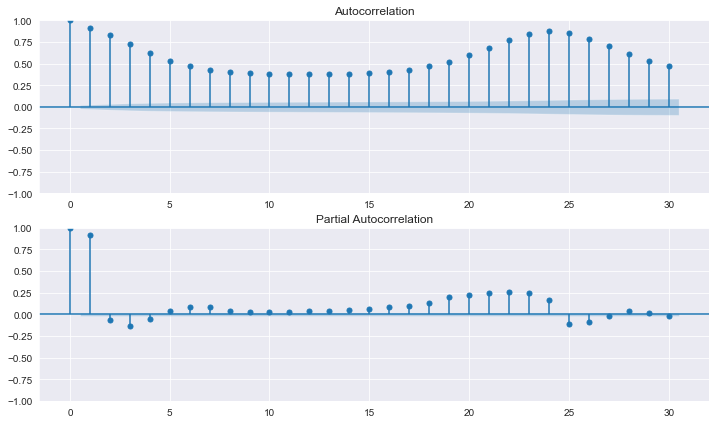

In [77]:
plot_acf_pacf(target_series)

The ACF chart shows that there is seasonality every 12/24 hours (the current value is highly correlated with the 12/24 lags)

More than 24 lags cannot be used

Wall time: 1.22 s


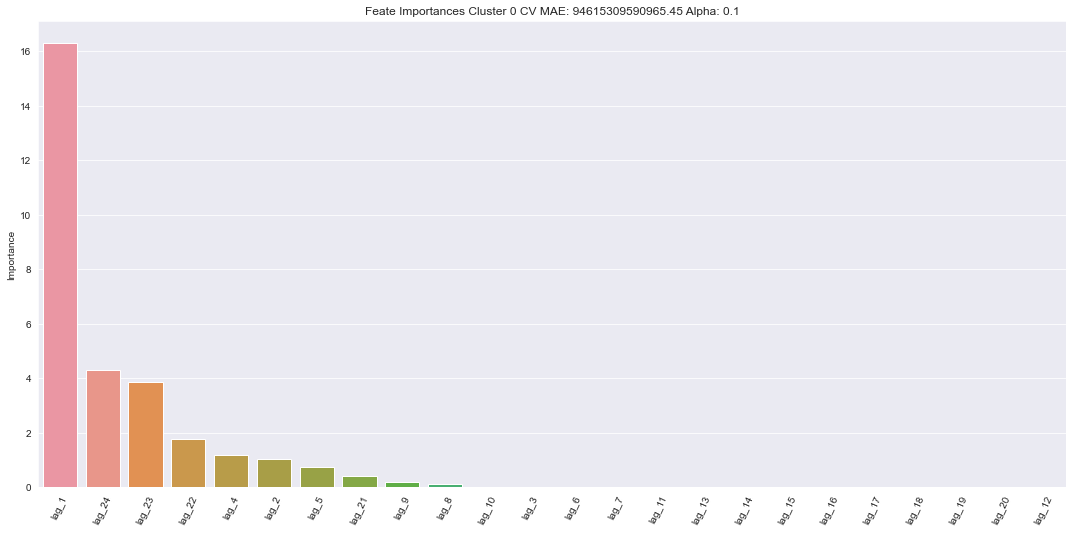

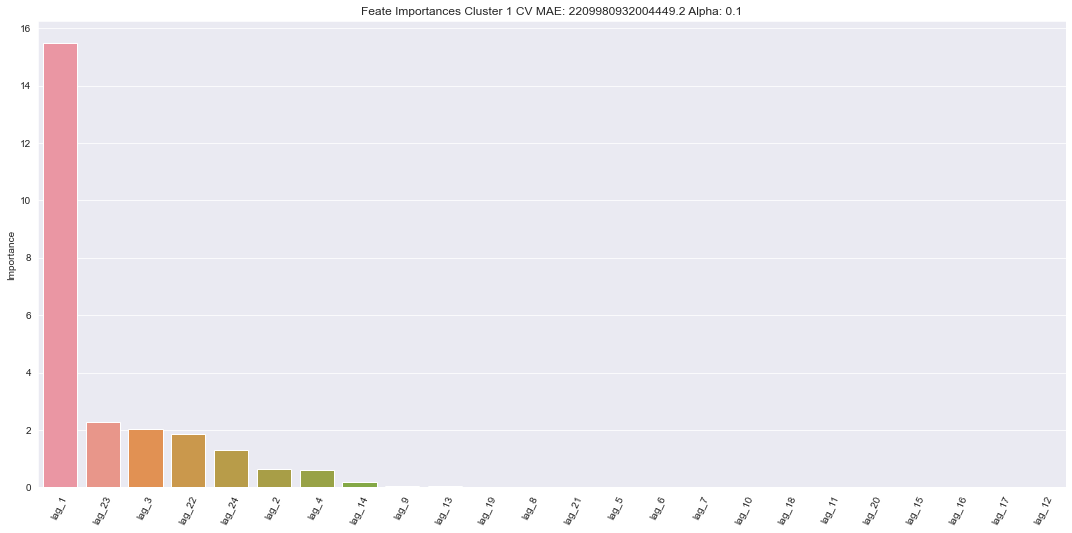

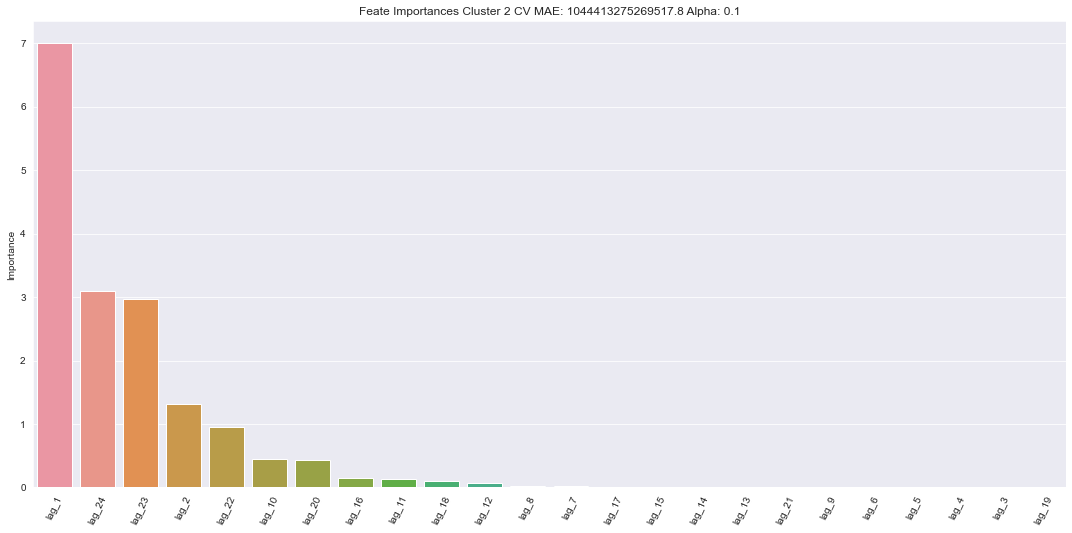

In [78]:
%%time
alphas = np.logspace(-5, -1, 10)

model_pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', LassoCV(cv=TimeSeriesSplit(5), alphas=alphas))
])

for indx, series in enumerate(centroids_serieses):
    series = pd.DataFrame(series, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])
    features = get_lags(series, target_col_name='n_trips', lag_start=1, lag_end=24, drop_target_col=False)
    show_features_importances(model_pipe, features, n_splits=5, 
                              scoring='neg_mean_absolute_percentage_error', target_col_name='n_trips', cluster_indx=indx)

It can also be seen that each model has its own significant lags. Lags are important for all target series:
- `lag_1, lag_6, lag_12, lag_24`

### Series Harmonics

Wall time: 16.2 s


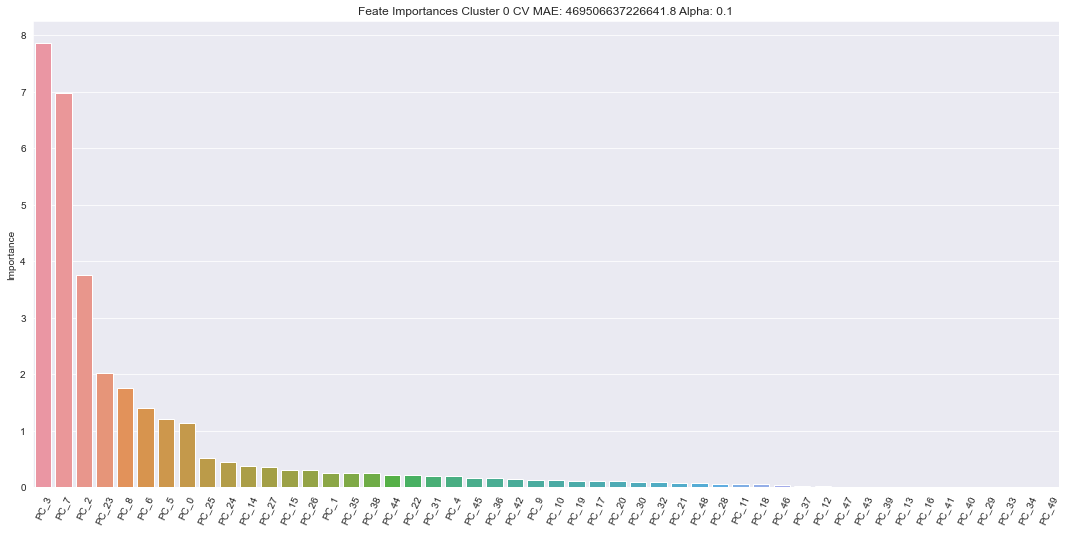

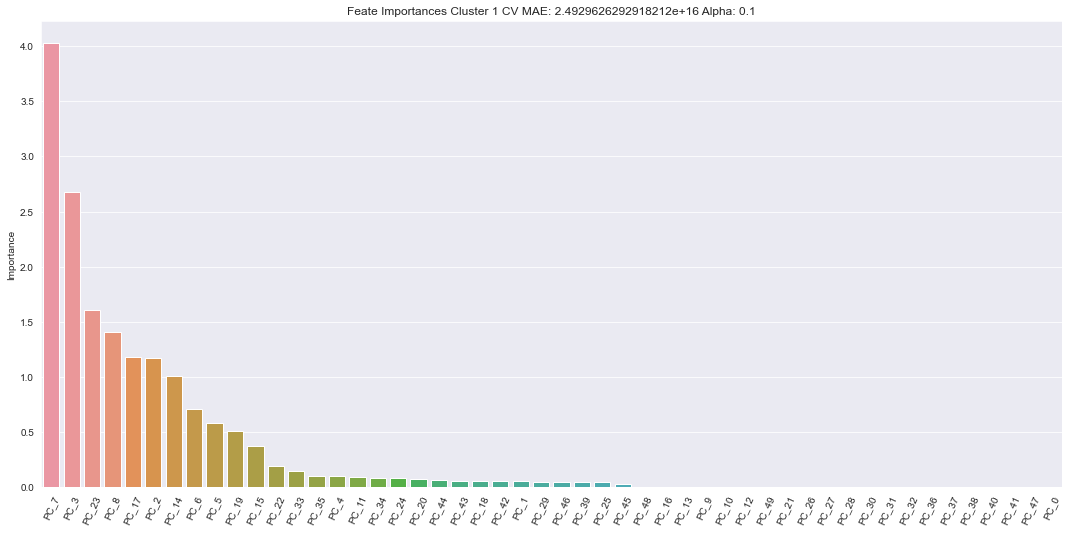

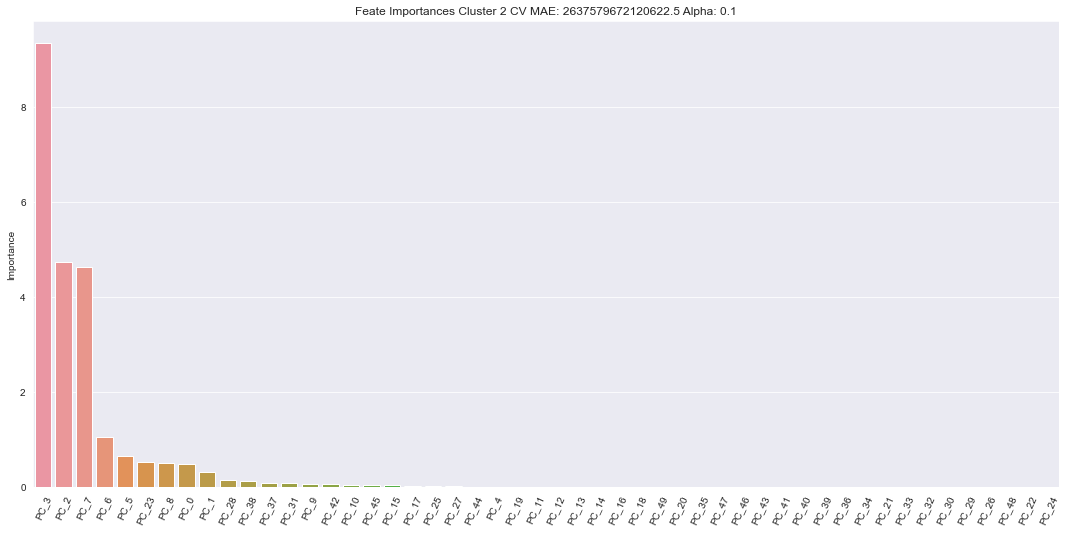

In [79]:
%%time
alphas = np.logspace(-5, -1, 10)

model_pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', LassoCV(cv=TimeSeriesSplit(5), alphas=alphas))
])

for indx, series in enumerate(centroids_serieses):
    series = pd.DataFrame(series, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])
    # Features 
    harmonics_features = get_harmonics_df(series, func='sin')
    harmonics_features_pca = pd.DataFrame(downsize_features_pca(harmonics_features, seed=SEED), index=series.index)
    harmonics_features_pca.columns = [f'PC_{i}' for i in harmonics_features_pca.columns]
    harmonics_features_pca['n_trips'] = series['n_trips']
    
    show_features_importances(model_pipe, features=harmonics_features_pca, n_splits=5, 
                              scoring='neg_mean_absolute_percentage_error', target_col_name='n_trips', cluster_indx=indx)

### Rolling Window Features
The main idea is to define a window of size n that slides/shifts through the time series and calculates some statistical values:
- Minimum/Maximum value
- Mean, Sum or Standard Deviation

The window size is fixed and important. For example, we can calculate 12/24 hourly, daily or weekly averages

It is also worth considering that observations closer to the current date carry more information, so a weighted moving average can be used

Wall time: 801 ms


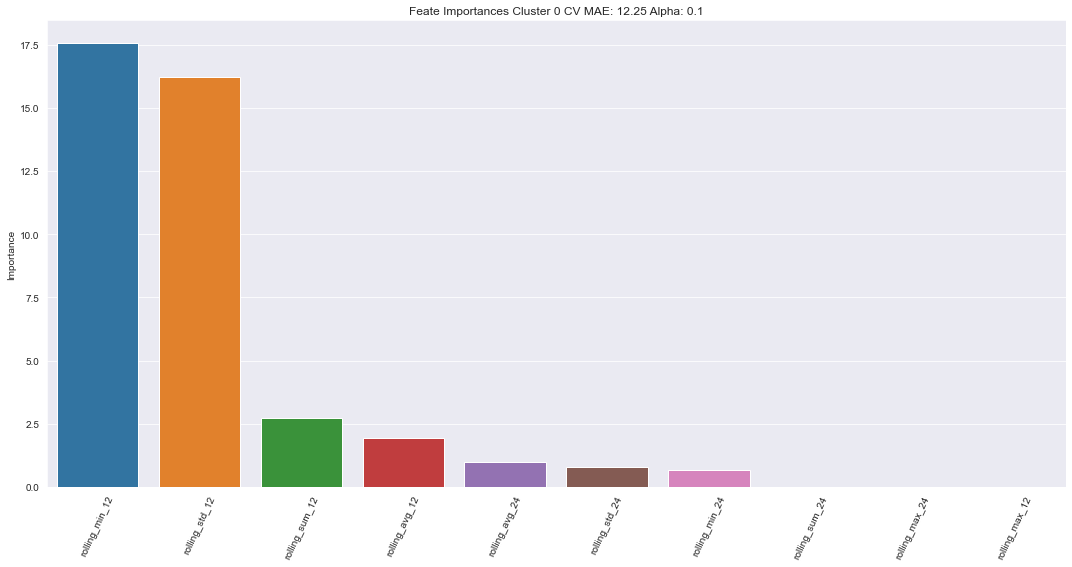

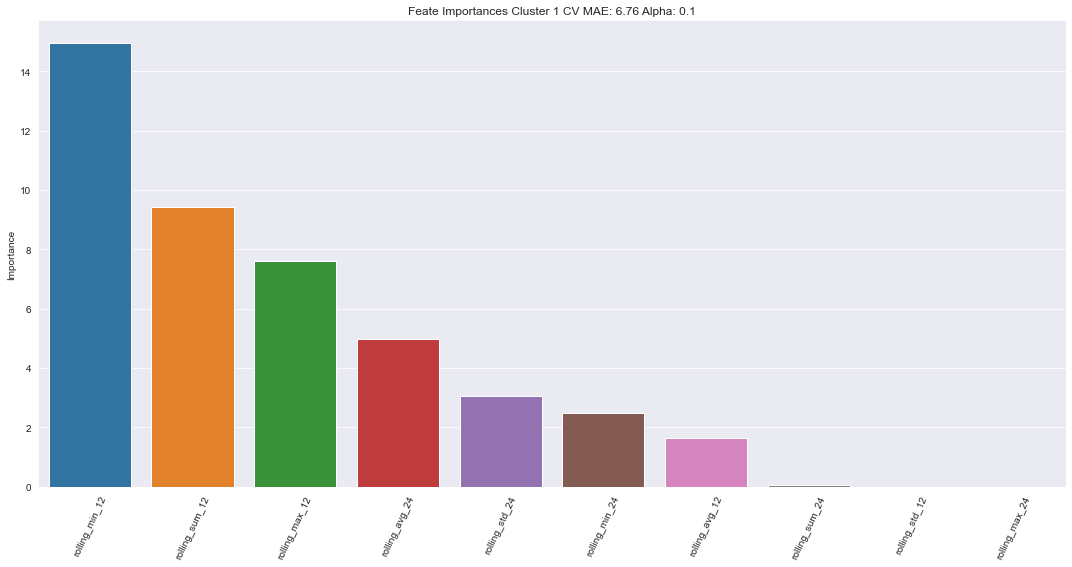

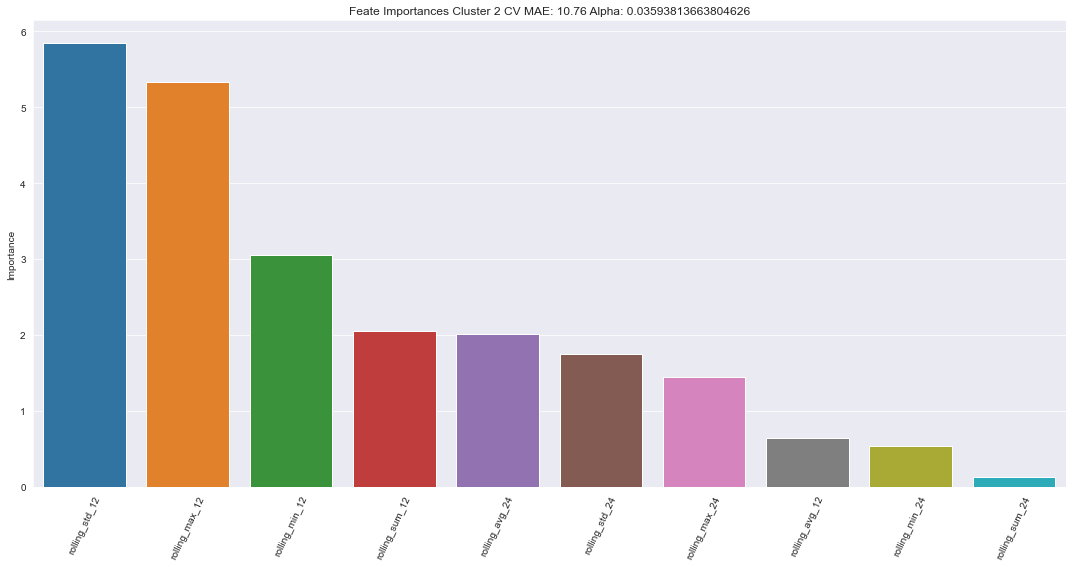

In [80]:
%%time
alphas = np.logspace(-5, -1, 10)

model_pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', LassoCV(cv=TimeSeriesSplit(5), alphas=alphas))
])

for indx, series in enumerate(centroids_serieses):
    series = pd.DataFrame(series, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])
    # Features
    features = get_rolling_window_features(series,
                                           target_col_name='n_trips',
                                           window_size=[12, 24],
                                           statistics=['avg', 'min', 'max', 'sum', 'std'])

    
    show_features_importances(model_pipe, features, n_splits=5, 
                              scoring='neg_mean_absolute_error', target_col_name='n_trips', cluster_indx=indx)

### Expanding Window Features
Unlike the sliding window, here the size of the window is constantly increasing/expanding. We can calculate the same statistics

Wall time: 784 ms


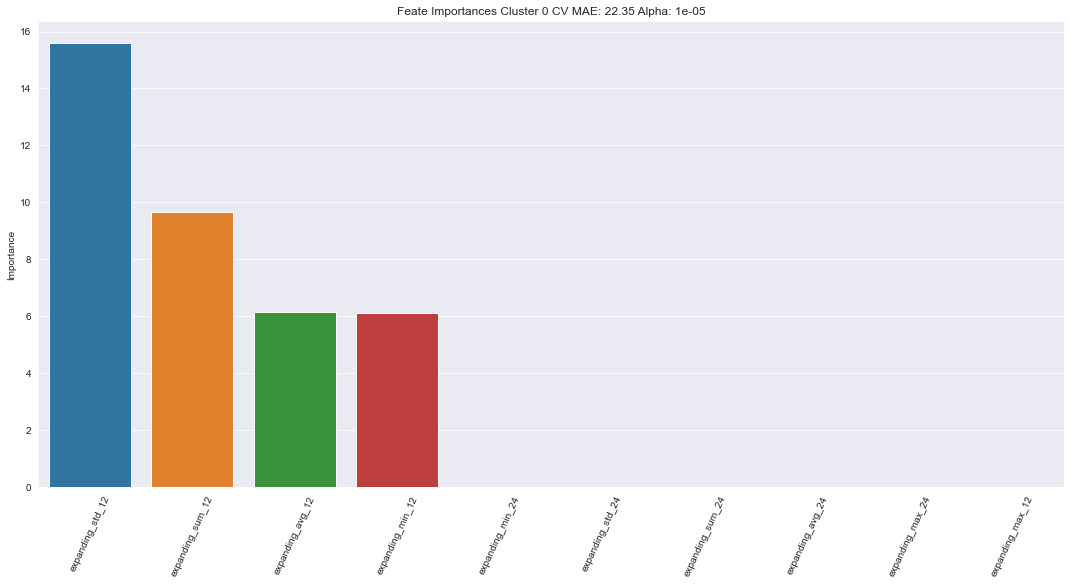

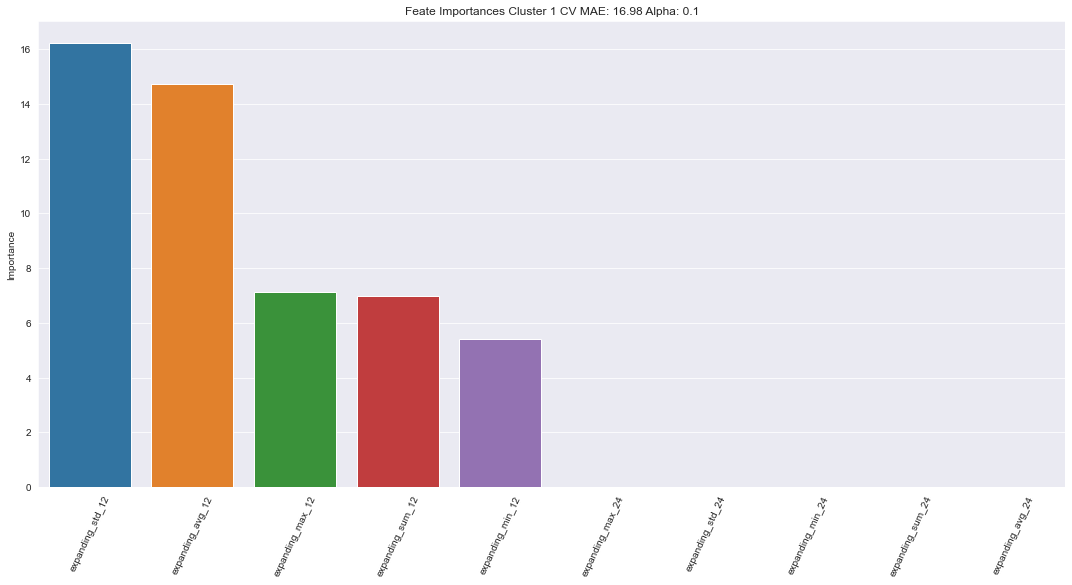

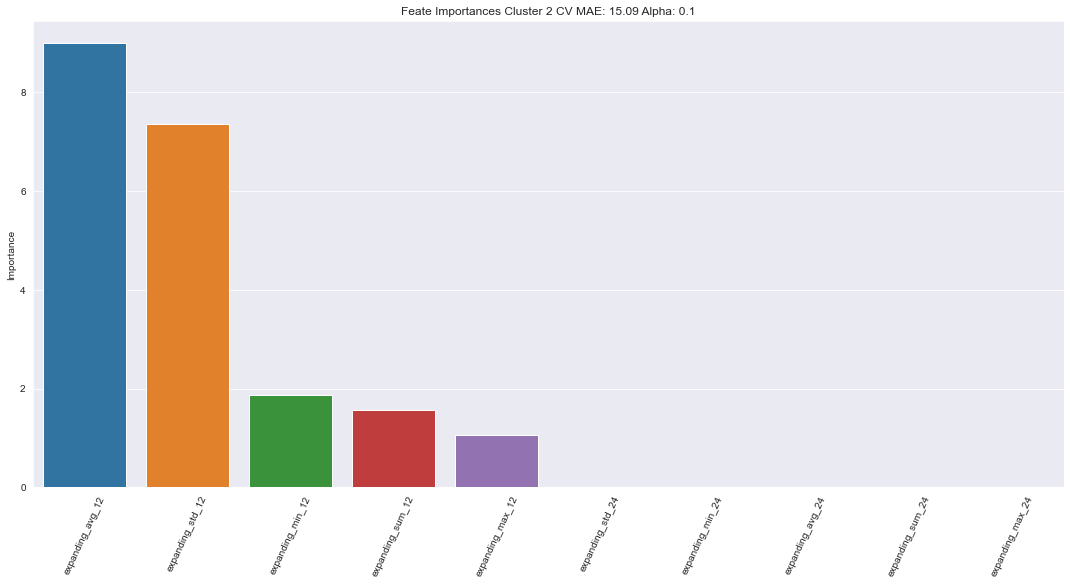

In [81]:
%%time
alphas = np.logspace(-5, -1, 10)

model_pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('model', LassoCV(cv=TimeSeriesSplit(5), alphas=alphas))
])

for indx, series in enumerate(centroids_serieses):
    series = pd.DataFrame(series, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])
    # Features
    features = get_expanding_window_features(series,
                                             target_col_name='n_trips',
                                             window_size=[12, 24],
                                             statistics=['avg', 'min', 'max', 'sum', 'std'])

    
    show_features_importances(model_pipe, features, n_splits=5, 
                              scoring='neg_mean_absolute_error', target_col_name='n_trips', cluster_indx=indx)

These features are not very useful. It is possible to use `expanding_std_12 expanding_avg_12` window larger than 12 observations is inefficient

### Training Cluster Models
We conducted a series of experiments and now we have an idea of what features are important for a particular model. Next, we need to create a `train/test data` preparation pipeline for each cluster. In order to save time, we will not do this (this is a further option for improvement). Instead of this, we will create one pipeline and a model with feature regularization `Lasso`

In [82]:
# To be able to use custom metrics, use Sklearn make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=True)
adj_r2 = make_scorer(adjusted_rsquare, greater_is_better=True)

In [101]:
# Function for obtaining the final set of features (parameters need to be changed in the functions themselves)
def get_features_df(series, seed):
    # Time Features
    time_features = get_time_features(series, is_cyclical_encoding=False) # возвращает с таргетом
    # Lag Features
    lag_features = get_lags(series, target_col_name='n_trips', lag_start=1, lag_end=24, drop_target_col=True)
    # Harmonics
    harmonics_features = get_harmonics_df(series, func='sin')
    harmonics_features_pca = pd.DataFrame(downsize_features_pca(harmonics_features, seed=seed), index=series.index)
    harmonics_features_pca.columns = [f'PC_{i}' for i in harmonics_features_pca.columns]
    
    # Rolling Window Features
    rolling_features = get_rolling_window_features(series,
                                                   target_col_name='n_trips',
                                                   window_size=[12, 24],
                                                   statistics=['avg', 'min', 'max', 'sum', 'std'],
                                                   drop_target_col=True)
    # Expanding Window Features
    expanding_features = get_expanding_window_features(series,
                                                       target_col_name='n_trips',
                                                       window_size=[12, 24],
                                                       statistics=['avg', 'min', 'max', 'sum', 'std'],
                                                       drop_target_col=True)
    
    # Get rid of msiing values and align the final feature DF
    res_features_df = pd.concat([time_features, lag_features, harmonics_features_pca,
                                rolling_features, expanding_features], axis='columns').dropna()
    return res_features_df

In [129]:
# Train cluster models 
cluster_models = {}
for indx, series in enumerate(centroids_serieses):
    series = pd.DataFrame(series, index=pd.to_datetime(train_data.T.iloc[1:, :].index), columns=['n_trips'])
    
    # et the feature matrix and scale it
    res_features_df = get_features_df(series, SEED)
    scaler_train = StandardScaler()
    scaled_features = scaler_train.fit_transform(res_features_df)
    
    # Train Data
    X_train = scaled_features[:, 1:]
    y_train = scaled_features[:, 0]
    
    # Model 
    model = LassoCV(cv=TimeSeriesSplit(5), alphas=alphas)
    
    # Cross-validation quality
    cv = cross_val_score(model, X_train, y_train,
                         cv=TimeSeriesSplit(5),
                         scoring=mape_scorer,
                         n_jobs=-1)
    
    cv_mae = cv.mean()
    print(f'Cluster {indx} CV MAPE: ', cv_mae)
    
    # Model Training 
    model.fit(X_train, y_train)
    cluster_models[f'Cluster_Model_{indx}'] = model

Cluster 0 CV MAPE:  51.1800856820969
Cluster 1 CV MAPE:  47.68973048452154
Cluster 2 CV MAPE:  10.893738389433473


### Inference
Let's take a look at the test data. First, we cluster the test series and predict using the cluster model

In [130]:
cluster_serieses = pd.read_csv('cluster_serieses.csv', parse_dates=['tpep_pickup_datetime'])

# Inference
inference_data = pd.read_csv('inference_data.csv', parse_dates=['tpep_pickup_datetime'])

In [131]:
# Predict cluster labels
cluster_labels = predict_cluster_labels(kmeans_model, tsne, inference_data)
 
inf_data = inference_data.pivot(index='PULocationID', columns='tpep_pickup_datetime', values='n_trips').T

forecast = {} # cluster models predictions
actual = {} # true values 

for indx, district in enumerate(inf_data.columns):
    current_series = pd.DataFrame(inf_data[district]).rename(columns={district: 'n_trips'})
    
    # Get the feature matrix and scale it using scaler_train
    res_features_df = get_features_df(current_series, SEED)
    scaled_features = scaler_train.transform(res_features_df)
    
    # Train Data
    X_test = scaled_features[:, 1:]
    y_test = scaled_features[:, 0]
        
    # Determining a cluster model from a predicted cluster label
    cluster_index = cluster_labels[indx]
    preds = cluster_models[f'Cluster_Model_{cluster_index}'].predict(X_test)

    mape = mean_absolute_percentage_error(preds, y_test)
    print(f'Test MAPE For District {district} Cluster_{cluster_index}: ', mape)
    
    # Save results
    forecast[f'District_{district}'] = preds
    actual[f'District_{district}'] = y_test
    
# print('Avg MAE All Clusters: ', np.mean(mae_all))

Test MAPE For District 10 Cluster_2:  0.7470579856802547
Test MAPE For District 41 Cluster_1:  428.35081271523904
Test MAPE For District 43 Cluster_2:  8.482883118282665
Test MAPE For District 132 Cluster_2:  48.46650093659248
Test MAPE For District 179 Cluster_0:  164.92415675622962


It can be seen that for some series the error is very large. The MAPE metric is more than 100% - large deviations between the forecast and the true values. It can be assumed that the problem is not in features, but in wrong clustering.

It can be seen that for some series, for example, `District 41` the error is very large, and for others it is small

This can be explained by the fact that the series is predicted by the wrong model, hence such large deviations 

### Weekly Forecast (District 132)

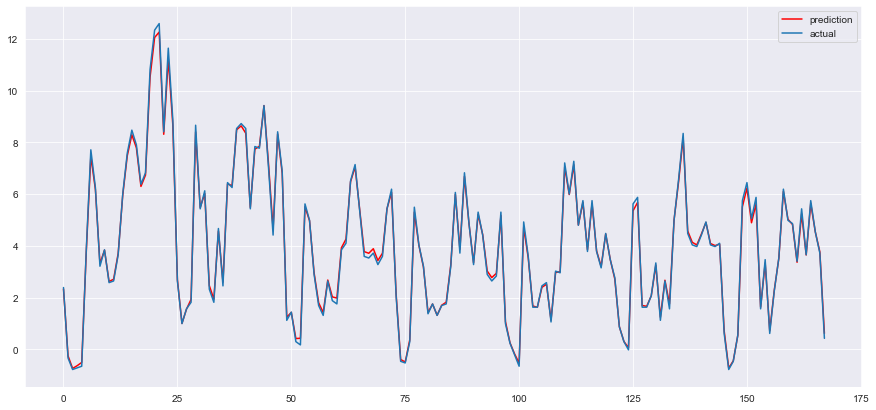

In [136]:
plt.figure(figsize=(15, 7))
plt.plot(forecast['District_132'][:168], "r", label="prediction")
plt.plot(actual['District_132'][:168], label="actual")
plt.legend(loc="best")
plt.grid(True);

### Weekly Forecast (Район 179) 

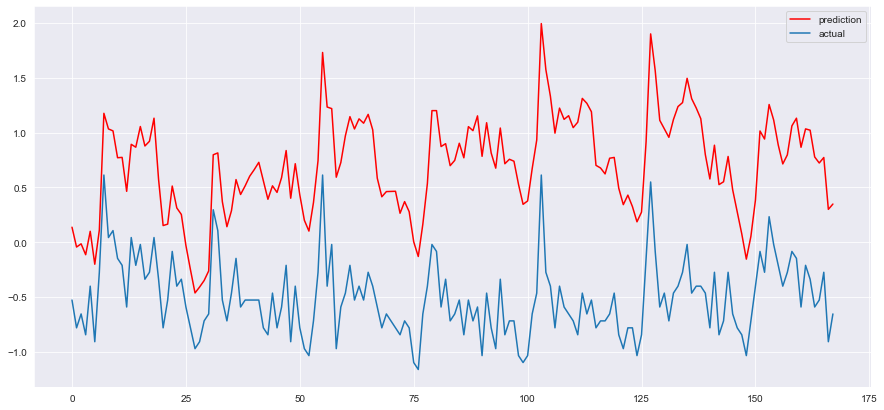

In [143]:
plt.figure(figsize=(15, 7))
plt.plot(forecast['District_41'][:168], "r", label="prediction")
plt.plot(actual['District_41'][:168], label="actual")
plt.legend(loc="best")
plt.grid(True);

An illustrative example of misclustering and the model used

### Conclusion
The results obtained are not the best. You can experiment with other clustering algorithms that have been covered in the `4_TimeSeries_Clustering` notebook. Perhaps they will give the best clustering quality and, as a result, the best quality of the forecast (there are noise series that spoil the quality of clustering)

The main task was to experiment with time series clustering algorithms, data preparation and feature extraction. Also try in practice to use the clustering of time series and their forecasting using a cluster model